<span style="font-family: Palatino; font-size: 40px; color: purple">
             Measuring Classifier Performance - I
</span>


Spring 2022 - Instructors: Roger Stein and Ben Wolfson -
***

In [2]:
from IPython.core.display import HTML

HTML("""

    <STYLE type="text/css">
       H1 {font-family: Palatino; font-size: 30px; color: purple}
    </STYLE>

""")

In [3]:
HTML( 
    """
<a href=\"https://colab.research.google.com/github/bwolfson2/dsclass2022/blob/main/Module_3_Validating_Models/Module_3_Validating_Models_I.ipynb\" target=\"_parent\"> <img src=\"https://colab.research.google.com/assets/colab-badge.svg\" alt=\"Open In Colab\" /> </a>
    """
)

Today we are going to be learning about how to evaluate a model's performance. But before diving into the nitty gritty, let's try to understand why we need to evaluate a model in the first place. Why can't we just build a model on our data, get it as close to 100% accurate as possible and continue on to the next project?

In order to explore this topic, we turn back to polynomial regressions, before looking at an example on a real dataset.

# Setup and houskeeping

## If running in colab:

In [15]:
!git clone https://github.com/bwolfson2/dsclass2022
%cd dsclass2022/Module_3_Validating_Models/

Cloning into 'dsclass2022'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 98 (delta 34), reused 80 (delta 20), pack-reused 0
Unpacking objects: 100% (98/98), done.
/content/dsclass2022


## Import the libraries we will be using

In [5]:
import os
import warnings
import copy as cp
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from IPython.display import display, clear_output

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [ ]:
# If you have not installed `pandas` or `dataprep`, run this chunk

!pip install -U dataprep
## If NOT running in Colab
#!pip install pandas==1.3.2

In [7]:
from dataprep.datasets import load_dataset
from dataprep.eda import create_report

## Define some helper functions

### For data description and transformation

In [8]:
def count_classes(x):
    N = df.shape[0]
    m = np.sum(x)
    n = N - m
    print("{:>10,}".format(N), "records in total.")
    print("{:>10,}".format(m) + " positive (1) instances.")
    print("{:>10,}".format(n) + " negative (0) instances.")
    return N, m, n


def discretize_Y(Y, threshold):
    Y = pd.DataFrame(Y)
    Y = Y > threshold
    return Y


def print_confusion_matrix(M, nclass=2):
    col_names = M.columns
    ncol = len(col_names)
    row_names = M.index
    nrow = len(row_names)

    print('{:>8}'.format(''), end='')
    for j in range(ncol):  # horiz header
        print('{:>8}'.format(col_names[j]), end='')
    print('')

    for i in range(nrow):
        print('{:>8}'.format(row_names[i]), end='')
        for j in range(ncol):
            print('{:>8,}'.format(M.iloc[i, j]), end='')
        print('')

### For review of polynomial example (see "Linear Models" notebook).

In [9]:
line_color = ['blue', 'violet', 'red']


def true_function(X):
    return np.sin(1.5 * np.pi * X)


def plot_example(X, Y, functions):
    # Get some X's to plot the functions
    X_test = pd.DataFrame(np.linspace(0, 1, 100), columns=['x1'])
    # Plot stuff
    for i, key in enumerate(functions):
        plt.plot(X_test,
                 functions[key](X_test),
                 label=key,
                 color=line_color[i],
                 linewidth=3)
    plt.scatter(X, Y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")


def fit_polynomial(X, Y, degree):
    # create different powers of X
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X, Y)
    return pipeline


def plot_poly(X, Y, degree):
    # Fit polynomial model
    model = fit_polynomial(X, Y, degree)
    # Evaluate model
    mse = mean_squared_error(Y, model.predict(X))
    # Plot results
    functions["Model"] = model.predict
    plt.title("Degree %d\n MSE: %.2f" % (degree, mse))
    plot_example(X, Y, functions)

### Generally useful utilities

In [10]:
def progress_bar(k, n, incr_txt="Step", bar_len=10):

    bar_char = u'\u25A5'
    line_char = u'\u21E2'  # u'\u2192'  u'\u23AF' u'\u25AD'

    places = int(np.ceil(n / bar_len))
    pct = k / n
    n_str = "{:,.0f}".format(n)
    k_str = "{:,.0f}".format(k)
    pct_str = "{:,.0f}%".format(k / n * 100)
    # d_format = "%" + str(places) + "d"

    if k == n - 1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = (
            '\u25BB' * 10
        ) + " Completed " + n_str + " " + incr_txt + "s. " + '\u25C5' * 10
    else:
        n_bars = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str + " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt = "[" + "".ljust(n_bars, bar_char) + "".rjust(n_spaces,
                                                          line_char) + "]  "

    clear_output()
    display(bar_txt + text_txt)


def vspace(k):
    spaces = ["\n" * k][0]
    print(spaces)


# Motivational examples

Recall from the last lecture that we experimented with fitting polynomial models to some noisy observations from a nonlinear function. We're going to approximate that function by fitting a polynomial to the observations. 

## Example 1: Fitting a polynomial to a contiunous function (see 'Linear Models' notebook)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

num_samples = 50
np.random.seed(42)

X = pd.DataFrame(np.sort(np.random.rand(num_samples)), columns=['x1'])
Y = true_function(X.x1) + np.random.randn(num_samples) * 0.5
functions = {"True function": true_function}

plt.figure(figsize=(14, 5))
# degrees of the polynomial
degrees = [1, 2, 4, 6, 8]
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    plot_poly(X, Y, degrees[i])
plt.show()

Well the fit certainly improved!
So now what...Which polynomial should we as our model..?

## Motivational example 2: Predicting wine quality

_"All wines should be tasted; some should only be sipped, but with others, drink the whole bottle."_ - Paulo Coelho, Brida

We will use a data set related to the red variant of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). Our goal is to use machine learning to detect above-average wines (perhaps to send these wines later to professional tasters?).

### Start by loading the data.

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=";").dropna()
df.head(5)

### Perform some basic data wrangling to clean up the column names and also look for duplicate records.

The variable names have spaces in them which makes it more cumbersome to compute with them.  We can clean this up:

In [ ]:
cols_old = df.columns
df.columns = [c.replace(' ', '_') for c in df.columns]
pd.DataFrame({"old": cols_old, "new": df.columns}).head(5)

Next, we've decided to check for duplicate records and, for purposes of this example, we will drop them.  (Why might we want to keep them instead?)

In [ ]:
dup_idx = df.duplicated(keep='first')
sum(dup_idx)

In [ ]:
df = df.drop_duplicates(keep="first")
sum(df.duplicated(keep='first'))

### Set up training and test data sets
Next we need to divide the data into a training set and a testing set.  

<img src="https://github.com/bwolfson2/dsclass2022/blob/main/Module_3_Validating_Models/images/sample_split.png?raw=1" alt="Splitting the data" style="width: 200px;"/>



In [17]:
from sklearn.model_selection import train_test_split

column_names = df.columns

predictor_columns = column_names[:-1]  # independent variable names
y_column = column_names[-1]

X = df[[x for x in predictor_columns]]
Y = df[y_column]

# Splitting the data into train and test!
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

Note above the "`pandas`" way of doing things: process all the instances simultaneously computing the mean in one swoop; assigning the new column all at once.  This is a form of *vectorization*.

Next we need to create a categorical variable from our raw target variable `quality`.

In [ ]:
avg_Y_train = np.mean(Y_train)
is_good = cp.copy(discretize_Y(Y_train, avg_Y_train).astype("int32"))
Y_train = cp.copy(is_good)
Y_train = Y_train.rename(columns={'quality': 'is_good'})
Y_train.describe()

(54% of our instances are of "good" quality.)

### Perform some basic EDA

In [ ]:
# create a data set to use for comparing distributions
# and looking at correlations
train_eda_dat = pd.concat([X_train, Y_train], axis=1)
train_eda_dat.is_good.astype("int32")
train_eda_dat.describe()

In [ ]:
warnings.filterwarnings('ignore')
report = create_report(train_eda_dat)

In [ ]:
report.show()

We can learn a bit more about our data from report above. 

Firstly, the target variable "is_good" does not appear to be not highly correlated with any of the dependent variables. 

There are also slight distributional skews in the variables, as well as in the interactions between `is_good` and other variables.  In a robust analysis, we would want  to consider various transformations, but for purposes of this example, we will skip that step. 

Finally, there are some high correlations among some of the variables.  We would normally need to deal with thhis too, but for the sake of the example (again!) we will pretend we don't see this.


###  Fitting a model to predict wine quality

In [22]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import warnings


def polynomial_model(model=LogisticRegression(), degree=1):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("model", model)])
    return pipeline


def training_accy(X_train, Y_train, X_test, Y_test, model):
    warnings.filterwarnings('ignore')
    y_hat = model.fit(X_train, Y_train).predict(X_test)
    return accuracy_score(Y_test, [1 if ty >= 0.5 else 0 for ty in y_hat])

Now we need to set up our test data the same way.  Notice we **did not** use the test data for any EDA and we will use the preprocessing parameter (`avg_Y_train`) from the training data, rather than reestimating it on the training data.  (Why?)

In [ ]:
is_good = cp.copy(discretize_Y(Y_test, avg_Y_train).astype("int32"))
Y_test = cp.copy(is_good)
Y_test = Y_test.rename(columns={'quality': 'is_good'})
Y_test.describe()

Now we can fit a number of candidate models and compare their in- and out-of-sample performance.  To get started, we will compute the `accuracy_score` for each model on both in-sample and out-of-sample data sets.  Recall that the $$accuracy\_score = \sum_i I(pred_i = actual_i),$$
where 
$$I(c) =  \Large\left[^{1: ~ c ~ is ~ TRUE, ~ and}_{0: ~otherwise}.~ \right.$$

In [ ]:
# from beepy import beep  # warning: this is an alpha package

degrees = [1, 2, 3, 4, 5, 10, 12]
n_degrees = len(degrees)
acc_in = np.zeros(n_degrees)
acc_out = np.zeros(n_degrees)

progress_bar(0, n_degrees, incr_txt="Finished polynomial fit", bar_len=20)

for i in range(n_degrees):
    model = polynomial_model(
        LogisticRegression(solver='liblinear', max_iter=1000), degrees[i])
    model.fit(X_train, Y_train.values)

    y_hat = model.predict(X_train)
    accy = accuracy_score(Y_train, [1 if ty >= 0.5 else 0 for ty in y_hat])
    acc_in[i] = accy

    y_hat = model.predict(X_test)
    accy = accuracy_score(Y_test, [1 if ty >= 0.5 else 0 for ty in y_hat])
    acc_out[i] = accy

    progress_bar(i, n_degrees, incr_txt="Polynomial fit", bar_len=20)
# beep(sound=10)

'[▥▥▥▥▥▥▥▥▥▥▥⇢⇢⇢⇢⇢⇢⇢⇢⇢]   57% (Polynomial fit 4 of  7).'

In [ ]:
scores = pd.DataFrame(
    data={
        "polynomial degree": degrees,
        "in-sample": np.round(acc_in, 2),
        "out-of-sample": np.round(acc_out, 2),
        "dif(i-o)": np.round(acc_in - acc_out, 2)
    })
vspace(2)
print(scores)

What do you notice about the results?  What explanation might you give?

# Going beyond `accuracy_score`: Contingency tables and confusion matrices 

## Example 3: Direct mailing 
We're going to use a mail response data set from a real direct marketing campaign located in `data/mailing.csv`. Each record represents an individual who was targeted with a direct marketing offer.  The offer was a solicitation to make a charitable donation. 

The columns (features) are:

| feature   | description |
| :---      |        ---: | 
|`income`   | household income |
|`Firstdate`| date assoc. with the first gift by this individual|
|`Lastdate` | date associated with the most recent gift |
|`Amount`   | average amount by this individual over all periods (incl. zeros)|
|`rfaf2`    | frequency code|
|`rfaa2`    | donation amount code|
|`pepstrfl` | flag indicating a star donor|
|`glast`    | amount of last gift|
|`gavr`     | amount of average gift|



The target variables is `class` and is equal to one if a donor made a contribution in the current campaign and zero otherwise.

In [ ]:
# Load the data
df = pd.read_csv("data/mailing.csv")
# Let's take a look at the data
df.head()

In [ ]:
n, ngood, nbad = count_classes(df['class'])

## Data prep
From the description above, and the head of the data, we see that two of the fields are **categorical** instead of typical **numerical** fields. In what follows, we will be estimating is a logistic model. From the previous classes, we have seen that logistic regression requires *all* fields to be numerical. So, we are going to create "dummy" variables for all the fields that are categorical (same as you did for your homework).  [I believe in sklearn all models require numeric variables; that's not the case for every implementation.]


A dummy variable is a binary variable corresponding to one value of a categorical variable.

The typical way to create dummies for a field is to create new variables for each possible category of the field. For example consider a field called color that can have the possible values "red", "blue", and "green". To dummyize color, we would create three new features: "color_red", "color_blue", and "color_green". These fields would take the value 1 or 0 depending on the actual value of color. Each record can only have one of these fields set to 1.

Notes:

- You can also leave out one of the possible categories. For example, in the above example that had three possible values, you can create only two dummies. This, because when "color_red"=0 and "color_blue"=0 it means that "color_green=1".  Often all three dummies are created anyway; it is slightly redundant, but makes the models more comprehensible.

- There also are cases where non-numeric variables can take on multiple values (for example, `colors = {red, white, blue}`).  In these cases again often binary variables are created for each value, the obvious difference being that now more than one can be non-zero (and you would need to represent all the values).
 

So.  Let's dummyize the fields `rfaa2` and `pepstrfl`.

In [ ]:
for field in ['rfaa2', 'pepstrfl']:
    dummies = pd.get_dummies(df[field])
    dummies.columns = [field + "_" + s for s in dummies.columns]
    df = pd.concat([df, dummies], axis=1).drop(field, axis="columns")

df.head()

## Confusion matrices
Let's build a confusion matrix using a logistic regression model. 

**Important and overlooked (always remember this!):** a confusion matrix is defined with respect to a classifier, not a scoring model.  However, our models *are* scoring models (e.g., class-probability estimation models).  So the confusion matrices are defined with respect a scoring model plus a *threshold* on the score.  The threshold should be chosen carefully, and with the business need in mind.   For binary classes, the default for most modeling programs when they return a predicted classification is to use a threshold corresponding to an estimated class probability of 0.5.  This is because the modeling program does not know the business setting, and 0.5 makes sense as a default (in expectation it gives the maximum classification accuracy, if the probabilities are well calibrated).

In class we saw this in terms of a Bankruptcy Model example:

<img src="https://github.com/bwolfson2/dsclass2022/blob/main/Module_3_Validating_Models/images/confusion_matrix.png?raw=1" alt="Schematic of Confusion Matrix" style="width: 600px;"/>
<span style="font-size: 10%"> <em>Stein, R. M., lecture notes, 2022</em></span>

$ $
$ $

So let's start with the default of predicting a 1 if the estimated probability is $\geq$ 50% and a 0 otherwise.

Remember, a confusion matrix looks like:

```
  |____________ p __________|___________ n ___________|
Y | 1's predicted to be 1's | 0's predicted to be 1's |
N | 1's predicted to be 0's | 0's predicted to be 0's |
```

In [ ]:
from sklearn import metrics

# Split our data into training and test sets
X = df.drop(['class'], axis=1)
Y = df['class']
X_mailing_train, X_mailing_test, Y_mailing_train, Y_mailing_test = train_test_split(
    X, Y, test_size=.25, random_state=42)

# Make and fit a model on the training data
model_mailing = LogisticRegression(C=1000000, solver='liblinear')
model_mailing.fit(X_mailing_train, Y_mailing_train)

# Get probabilities of being a donor (We saw this in a prior last class)
probabilities = model_mailing.predict_proba(X_mailing_test)[:, 1]

Now we can do some crude preprocessing on our independent variables to make it easier to work with the data.  We will need to do this again with the test data, so it is convenient to create a short function to do this.

Use the default threshold of 50% to predict a 1.

(An individual below this threshold will get a label "0" and someone above this will get a label "1")

In [ ]:
prediction = probabilities > 0.5

# Build and print a confusion matrix
confusion_matrix_p50 = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test,
                                                             prediction,
                                                             labels=[1, 0]).T,
                                    columns=['p', 'n'],
                                    index=['Y', 'N'])
print_confusion_matrix(confusion_matrix_p50)

Wait -- take a close look at that.  What's going on?

Incidentally, what would be the classification accuracy here?

What if we lower the threshold to 5%?

In [ ]:
# Let's move the threshold down
prediction = probabilities > 0.05

# Build and print a confusion matrix
confusion_matrix_p05 = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test,
                                                             prediction,
                                                             labels=[1, 0]).T,
                                    columns=['p', 'n'],
                                    index=['Y', 'N'])
print_confusion_matrix(confusion_matrix_p05)

***
Is this good performance? 

How can we tell?

(Incidentally, what would be the classification accuracy now?)

Is 5% the right threshold?  How would we determine that?

##  A more robust measure of discriminatory power: Receiver operating characteristic (ROC) curves

In the book, we were trying to predict if customers should be given a credit card.  Let's use a version of that example here:

- Target: `Y = 1` 
- Three features in `X_handson`: "earning", "geographic", and "experience".

Up until this point, when we need a "single number metric" for generalization performance, we have been using "vanilla" classification accuracy (the number of records correctly classified divided by the total number of records). However, classification accuracy usually does not  give us the "best" interpretation of our model's performance for a particular business problem. An more general evaluation is to visualize and measure the performance of a model using the Reciever Operating Characteristic **(ROC) curve**. 

Let's first specify how we create ROC curves: For each threshold $t$ that is chosen, we can define two quantities. First, the false positive rate, $FPR = \frac{False Positives}{False Positives+True Negatives}$, and second, the true positive rate, $TPR = \frac{True Positives}{True Positives+False Negatives}$. The ROC curve is the result of plotting $FPR$ against $TPR$ for each value of $t$ that is possible in the data.  It helps us to visualize and analyze the trade-offs between the opportunity for benefits (via true positives) and the possibility of costs (via false positives). 

" The lower left point **(0, 0) represents the strategy of never issuing a positive classification**; such a classifier commits no false positive errors but also gains no true positives. The opposite strategy, of unconditionally issuing positive classifications, is represented by the upper right point (1, 1). The point **(0, 1) represents perfect classification** (the star in Figure 8-3). The diagonal line connecting (0, 0) to (1, 1) represents the policy of guessing a class (for example, by flipping a weighted coin). "  

- _Provost, Foster, and Tom Fawcett. Data Science for Business: _
  _What you need to know about data mining and data-analytic thinking. O'Reilly Media, Inc., 2013._



<img src="https://github.com/bwolfson2/foster_in_dev/blob/master/Module5_ROC_Cost_Visualization/images/ROC1.png?raw=1" alt="Drawing" style="width: 600px;"/>
<img src="https://github.com/bwolfson2/foster_in_dev/blob/master/Module5_ROC_Cost_Visualization/images/ROC2.png?raw=1" alt="Drawing" style="width: 600px;"/>
<img src="https://github.com/bwolfson2/foster_in_dev/blob/master/Module5_ROC_Cost_Visualization/images/ROC3.png?raw=1" alt="Drawing" style="width: 600px;"/>


Doing this in **sklearn** is relatively straightforward.

Let's create a **new DATA SET** for this, that will show differences between different models.  We will build logistic regression models with different regularization parameters.

'[▥▥▥▥▥▥▥▥▥▥▥▥▥▥▥▥▥▥▥▥]   100% (Estimation/Evaluation 3 of  3).'

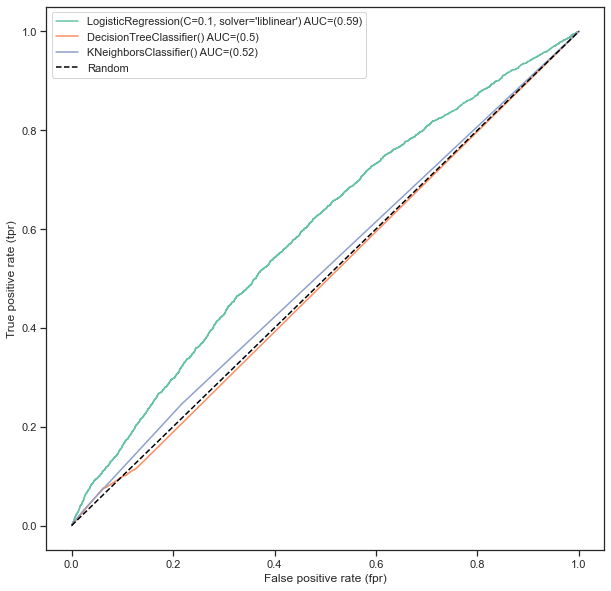

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize=(10, 10))
model_forms = ["Logistic", "Tree", "KNN"]
n_model_forms = len(model_forms)
progress_bar(0, 3, incr_txt=model_forms[0], bar_len=20)

# Fit a logistic regression model
for i, model in enumerate([
        LogisticRegression(C=.1, solver='liblinear'),
        DecisionTreeClassifier(),
        KNeighborsClassifier(n_neighbors=5)
]):
    model.fit(X_mailing_train, Y_mailing_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_mailing_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_mailing_test,
                                             Y_test_probability_1)

    # Compute (estimate) the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))

    # Plot the ROC curve
    label = f"{model} AUC=({str(round(auc, 2))})"
    plt.plot(fpr, tpr, label=label)

    progress_bar(i, n_model_forms, incr_txt=model_forms[i], bar_len=20)

progress_bar(n_model_forms,
             n_model_forms,
             incr_txt="Estimation/Evaluation",
             bar_len=20)
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.legend(loc='best')

Based only on the the ROC curves above, which model would you choose?  Can you imagine a situation in which you would prefer one of the other models over the one you chose?

In class, we learned that one definition of the AUC is the probability a randomly selected "good" instance being ranked better than a randomly chosen "bad" instance.

$$A = p(g~<~b),~ g \in G, ~b \in B$$
or, empirically,
$$\hat(A)=\frac{1}{mn}\sum_j^n \sum_i^m ~ I(G_j < B_j)$$

Let's see if this is really the case.

First, let's see how big the test sample is: 

In [ ]:
n, ngood, nbad = count_classes(Y_mailing_test)

   191,779 records in total.
     2,423 positive (1) instances.
   189,356 negative (0) instances.


This set of comparisons is large ($191,779$ _positive_ $\times~ 2,423$ _negative_ $= 464,680,517$, and would took about a minute to calculate on a fast desktop computer.  

But imagine if we had to calculate Equation (2) for a more evenly balanced data set, say $200,000$ bads and $200,000$ goods.  Calculating Equation (2) explicitly would require $40,000,000,000$ comparisons, or about 1:30 hours. If we had an evenly balanced data set with only $2,000,000$ records in total, this would be would require about six days.   

Fortunately, we can approximate Equation (2) by sampling the data, rather than using all of it.  In this case, this would mean taking a random sample of the contributors and a random sample of non-contributors and then compare them instance-wise to calculate Equation (2).

In [ ]:
from random import choices

np.random.seed(61)

n_samples = 100000

GLM_mailing = LogisticRegression(C=1000000, solver='liblinear')
GLM_mailing.fit(X_mailing_train, Y_mailing_train)
probabilities = GLM_mailing.predict_proba(X_mailing_test)[:, 1]

GLM_auc = np.mean(
    cross_val_score(GLM_mailing,
                    X_mailing_test,
                    Y_mailing_test,
                    scoring="roc_auc",
                    cv=5))

G = probabilities[Y_mailing_test == 1]
B = probabilities[Y_mailing_test == 0]

G_sample = choices(G, k=n_samples)
B_sample = choices(B, k=n_samples)

n_G_less_than_B = [
    0 if G_sample[i] < B_sample[i] else 1 for i in range(n_samples)
]
GLM_auc_samp = np.sum(n_G_less_than_B) / n_samples

print("{:>12} : {:>6}".format("Full AUC", round(GLM_auc, 4)))
print("{:>12} : {:>6}".format("Sample AUC", round(GLM_auc_samp, 4)))

    Full AUC : 0.5943
  Sample AUC : 0.5967


The two results are, for practical purposes, identical.